In [61]:

import numpy as np

import warnings
import seaborn as sns

from scipy.stats import chi2_contingency
from scipy import stats

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
warnings.filterwarnings('ignore')
matplotlib.rc("font", family= 'Noto Sans CJK JP')
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix,classification_report
from imblearn.over_sampling import SMOTE

In [62]:
prd=pd.read_csv("/home/piai/바탕화면/2. Big Data 분석/products_completed.csv")
prd.head()

,제품번호,물품명,물품대분류,물품중분류,상품중량,물품분류
0,100021V2_0,2단무늬컵,식기/편백,자기,1p,식기/편백
1,100022V2_1,7곡딸기롤과자,과자,스낵,100g/10개입,간식
2,100023V2_2,7곡참식,식사대용,선식/생식,700g,가공식품/간편식
3,100024V2_3,가리비,생물수산,패류/갑각류,1.5kg,해산물
4,100025V2_3,가리비,생물수산,패류/갑각류,1kg,해산물


In [63]:
sales=pd.read_csv("/home/piai/바탕화면/2. Big Data 분석/Sales.csv")
sales.head()


,회원번호,회원상태,구매수량,구매금액,주문일시,배송시작일,배송완료일,사용 적립금,사용 포인트 네이버,주문취소여부,주문시간,제품번호,월,일,요일
0,1032097472,정상회원,1.0,7083,2021-01-02,NaN,NaN,0,0,1,13:00:00,100021783V2_1337,1,2,Saturday
1,1032097472,정상회원,1.0,29865,2021-01-02,2021-01-02,2021-01-02,0,0,0,13:00:00,100022137V2_1606,1,2,Saturday
2,1032097472,정상회원,1.0,23164,2021-01-02,2021-01-02,2021-01-03,0,0,0,13:00:00,100021452V2_1113,1,2,Saturday
3,369152832,정상회원,1.0,16655,2021-01-02,2021-01-02,2021-01-03,0,0,0,13:00:00,10002931V2_708,1,2,Saturday
4,1032097472,정상회원,1.0,8423,2021-01-02,NaN,NaN,0,0,1,13:00:00,100022085V2_1559,1,2,Saturday


In [225]:
mem_vip=pd.read_csv("/home/piai/바탕화면/2. Big Data 분석/KMeans결과_나이포함.csv")
mem_vip.head()

,회원번호,평균주문주기,평균주문금액,총구매횟수,마지막방문일경과일수,최저주문금액,최고주문금액,총사용적립금,성별,나이,결혼,수도권여부,cluster,RecencyScore,MonetaryScore,FrequencyScore,VIP여부
0,18764160,8.903226,43023.200000,15,26,9189,166554,0,여,68,기혼,1,2,3,3,4,0
1,18792000,0.000000,9955.000000,1,210,9955,9955,0,남,83,미기입,0,2,1,1,1,0
2,18942336,3.944444,102310.307692,13,12,11678,323918,28464,여,39,기혼,1,2,4,3,3,0
3,18949760,0.000000,35130.000000,1,32,35130,35130,0,여,73,미기입,0,2,2,1,1,0
4,19391488,0.000000,3159.000000,1,166,3159,3159,0,여,52,기혼,0,2,1,1,1,0


In [226]:
mem=pd.read_csv("/home/piai/바탕화면/2. Big Data 분석/members_completed.csv")
mem.head()

,회원번호,회원상태,성별,나이,등록카드,결혼,구독여부,주소지,세부주소지
0,18764160,정상회원,여,68,농협중앙회,기혼,False,서울특별시,성동구
1,18792000,정상회원,남,83,연결앱결제,미기입,False,강원도,강릉시
2,18942336,정상회원,여,39,신한은행,기혼,False,인천광역시,중구
3,18949760,정상회원,여,73,기업은행,미기입,미기입,강원도,홍천군
4,19391488,정상회원,여,52,연결앱결제,기혼,False,대전광역시,중구


In [66]:
# 필요한 파생변수:
    # 한달동안 구매 횟수
    # 한달동안 총금액

# 주문취소건 날리기
sales = sales[sales["주문취소여부"] == 0]
sales['주문일시'] = pd.to_datetime(sales['주문일시'], format='%Y-%m-%d')
sales['배송시작일'] = pd.to_datetime(sales['배송시작일'], format='%Y-%m-%d')
sales['배송완료일'] = pd.to_datetime(sales['배송완료일'], format='%Y-%m-%d')
sales['주문시간'] = pd.to_datetime(sales['주문시간'], format='%H:%M:%S')
first_order_dates = sales.groupby('회원번호')['주문일시'].min().reset_index(name='첫주문일시')
# 10월달 행 날리기
first_order_dates=first_order_dates[first_order_dates['첫주문일시'] < '2021-09-01'] 


In [67]:
first_order_dates

,회원번호,첫주문일시
0,18764160,2021-01-03
1,18792000,2021-04-05
2,18942336,2021-01-09
4,19391488,2021-05-19
5,19627200,2021-01-09
...,...,...
12384,1626518592,2021-08-31
12385,1626628096,2021-08-30
12490,1670400000,2021-01-02
12491,1670606016,2021-04-02


In [68]:
from datetime import timedelta
first_order_dates['두달뒤']=first_order_dates['첫주문일시'] + timedelta(days=60)

In [69]:
sales = pd.merge(sales, first_order_dates, on='회원번호', how='left')

In [70]:
sales

,회원번호,회원상태,구매수량,구매금액,주문일시,배송시작일,배송완료일,사용 적립금,사용 포인트 네이버,주문취소여부,주문시간,제품번호,월,일,요일,첫주문일시,두달뒤
0,1032097472,정상회원,1.0,29865,2021-01-02,2021-01-02,2021-01-02,0,0,0,1900-01-01 13:00:00,100022137V2_1606,1,2,Saturday,2021-01-02,2021-03-03
1,1032097472,정상회원,1.0,23164,2021-01-02,2021-01-02,2021-01-03,0,0,0,1900-01-01 13:00:00,100021452V2_1113,1,2,Saturday,2021-01-02,2021-03-03
2,369152832,정상회원,1.0,16655,2021-01-02,2021-01-02,2021-01-03,0,0,0,1900-01-01 13:00:00,10002931V2_708,1,2,Saturday,2021-01-02,2021-03-03
3,369152832,정상회원,1.0,2489,2021-01-02,2021-01-02,2021-01-02,0,0,0,1900-01-01 13:00:00,100022160V2_1623,1,2,Saturday,2021-01-02,2021-03-03
4,441813376,정상회원,2.0,19144,2021-01-03,2021-01-05,2021-01-05,0,0,0,1900-01-01 13:00:00,100021509V2_1149,1,3,Sunday,2021-01-02,2021-03-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
632239,1523874368,정상회원,1.0,166554,2021-10-19,2021-10-20,2021-10-20,0,0,0,1900-01-01 01:00:00,100022543V2_1912,10,19,Tuesday,2021-05-12,2021-07-11
632240,402835520,정상회원,1.0,12635,2021-10-23,2021-10-23,2021-10-24,0,0,0,1900-01-01 01:00:00,10002432V2_327,10,23,Saturday,2021-01-02,2021-03-03
632241,402835520,정상회원,1.0,7849,2021-10-23,2021-10-23,2021-10-23,0,0,0,1900-01-01 01:00:00,100022317V2_1725,10,23,Saturday,2021-01-02,2021-03-03
632242,1544381312,정상회원,1.0,7275,2021-10-27,2021-10-27,2021-10-28,6270,0,0,1900-01-01 01:00:00,10002723V2_563,10,27,Wednesday,2021-01-08,2021-03-09


In [71]:
sales = sales[sales['주문일시'] <= sales['두달뒤']]

In [72]:
sales

,회원번호,회원상태,구매수량,구매금액,주문일시,배송시작일,배송완료일,사용 적립금,사용 포인트 네이버,주문취소여부,주문시간,제품번호,월,일,요일,첫주문일시,두달뒤
0,1032097472,정상회원,1.0,29865,2021-01-02,2021-01-02,2021-01-02,0,0,0,1900-01-01 13:00:00,100022137V2_1606,1,2,Saturday,2021-01-02,2021-03-03
1,1032097472,정상회원,1.0,23164,2021-01-02,2021-01-02,2021-01-03,0,0,0,1900-01-01 13:00:00,100021452V2_1113,1,2,Saturday,2021-01-02,2021-03-03
2,369152832,정상회원,1.0,16655,2021-01-02,2021-01-02,2021-01-03,0,0,0,1900-01-01 13:00:00,10002931V2_708,1,2,Saturday,2021-01-02,2021-03-03
3,369152832,정상회원,1.0,2489,2021-01-02,2021-01-02,2021-01-02,0,0,0,1900-01-01 13:00:00,100022160V2_1623,1,2,Saturday,2021-01-02,2021-03-03
4,441813376,정상회원,2.0,19144,2021-01-03,2021-01-05,2021-01-05,0,0,0,1900-01-01 13:00:00,100021509V2_1149,1,3,Sunday,2021-01-02,2021-03-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
632176,1189662592,정상회원,1.0,7083,2021-09-14,2021-09-14,2021-09-14,0,0,0,1900-01-01 01:00:00,100021629V2_1216,9,14,Tuesday,2021-08-22,2021-10-21
632181,1189662592,정상회원,1.0,4403,2021-09-14,2021-09-15,2021-09-15,0,0,0,1900-01-01 01:00:00,10002172V2_138,9,14,Tuesday,2021-08-22,2021-10-21
632182,1189662592,정상회원,1.0,4020,2021-09-14,2021-09-14,2021-09-14,0,0,0,1900-01-01 01:00:00,100021366V2_1045,9,14,Tuesday,2021-08-22,2021-10-21
632184,1189662592,정상회원,1.0,3733,2021-09-14,2021-09-15,2021-09-15,0,0,0,1900-01-01 01:00:00,10002527V2_406,9,14,Tuesday,2021-08-22,2021-10-21


In [73]:
tmp = sales[['회원번호','주문일시']].drop_duplicates()

In [113]:
diff = tmp.sort_values(by=['회원번호','주문일시'], ascending=True)

In [116]:
diff

,회원번호,주문일시
190412,18764160,2021-01-03
301005,18764160,2021-01-23
70127,18792000,2021-04-05
205048,18942336,2021-01-09
260355,18942336,2021-01-18
...,...,...
43996,1670620864,2021-04-26
34631,1670620864,2021-04-27
173777,1670620864,2021-04-28
333640,1670620864,2021-04-30


In [117]:
diff['주문시간차'] = diff.groupby('회원번호')['주문일시'].diff()

In [121]:
diff

,회원번호,주문일시,주문시간차
190412,18764160,2021-01-03,NaN
301005,18764160,2021-01-23,20.0
70127,18792000,2021-04-05,NaN
205048,18942336,2021-01-09,NaN
260355,18942336,2021-01-18,9.0
...,...,...,...
43996,1670620864,2021-04-26,1.0
34631,1670620864,2021-04-27,1.0
173777,1670620864,2021-04-28,1.0
333640,1670620864,2021-04-30,2.0


In [119]:
diff['주문시간차']= diff['주문시간차'].apply(lambda x : x.days)

In [122]:
diff.fillna(0,inplace=True)

In [124]:
diff = diff.groupby('회원번호')['주문시간차'].mean().reset_index(name='평균주문주기')
diff

,회원번호,평균주문주기
0,18764160,10.000000
1,18792000,0.000000
2,18942336,7.200000
3,19391488,0.000000
4,19627200,3.277778
...,...,...
11649,1626518592,7.500000
11650,1626628096,8.200000
11651,1670400000,1.034483
11652,1670606016,0.000000


In [80]:
tmp1 = tmp.groupby('회원번호')['주문일시'].count().reset_index(name='두달구매횟수')

In [81]:
tmp1

,회원번호,두달구매횟수
0,18764160,2
1,18792000,1
2,18942336,5
3,19391488,1
4,19627200,18
...,...,...
11649,1626518592,6
11650,1626628096,5
11651,1670400000,58
11652,1670606016,1


In [130]:
# # 한달동안 평균금액
buy_totPrice = sales.groupby(by = ["회원번호"])['구매금액'].sum().reset_index(name='두달구매금액')

In [131]:
buy_totPrice

,회원번호,두달구매금액
0,18764160,39053
1,18792000,9955
2,18942336,490087
3,19391488,3159
4,19627200,1094493
...,...,...
11649,1626518592,106268
11650,1626628096,56190
11651,1670400000,6628187
11652,1670606016,179284


In [132]:
tmp2 =pd.merge(diff, tmp1, on="회원번호", how="left")
tmp3 = pd.merge(tmp2, buy_totPrice, on="회원번호", how="left")

In [136]:
tmp3

,회원번호,평균주문주기,두달구매횟수,두달구매금액,최저주문금액,최고주문금액
0,18764160,10.000000,2,39053,NaN,NaN
1,18792000,0.000000,1,9955,NaN,NaN
2,18942336,7.200000,5,490087,NaN,NaN
3,19391488,0.000000,1,3159,NaN,NaN
4,19627200,3.277778,18,1094493,NaN,NaN
...,...,...,...,...,...,...
11649,1626518592,7.500000,6,106268,NaN,NaN
11650,1626628096,8.200000,5,56190,NaN,NaN
11651,1670400000,1.034483,58,6628187,NaN,NaN
11652,1670606016,0.000000,1,179284,NaN,NaN


In [137]:
tmp4 = sales.groupby(['회원번호','주문일시'])['구매금액'].sum().reset_index().groupby('회원번호')['구매금액'].min().reset_index(name='최저주문금액')

In [138]:
tmp5 = sales.groupby(['회원번호','주문일시'])['구매금액'].sum().reset_index().groupby('회원번호')['구매금액'].max().reset_index(name='최고주문금액')

In [139]:
tmp6 =pd.merge(tmp3, tmp4, on="회원번호", how="left")
tmp7 = pd.merge(tmp6, tmp5, on="회원번호", how="left")

In [141]:
tmp7 = tmp7.drop(['최저주문금액_x','최고주문금액_x'], axis=1)

In [143]:
sales['총사용적립금'] = sales['사용 적립금'] + sales['사용 포인트 네이버']

In [145]:
tmp8 = sales.groupby('회원번호')['총사용적립금'].sum().reset_index()

In [146]:
tmp9 = pd.merge(tmp7, tmp8, on="회원번호", how="left")

In [227]:
mem_vip = mem_vip[['회원번호','성별','나이','결혼','수도권여부','cluster']]

In [228]:
mem_vip

,회원번호,성별,나이,결혼,수도권여부,cluster
0,18764160,여,68,기혼,1,2
1,18792000,남,83,미기입,0,2
2,18942336,여,39,기혼,1,2
3,18949760,여,73,미기입,0,2
4,19391488,여,52,기혼,0,2
...,...,...,...,...,...,...
12330,1644772352,여,50,기혼,0,2
12331,1644957952,여,34,미혼,0,2
12332,1645334720,남,24,미혼,0,2
12333,1670606016,남,19,미혼,0,2


In [229]:
encoder = LabelEncoder()
cols=['성별','결혼']
for i in cols :
    mem_vip[i] =encoder.fit_transform(mem_vip[i])
mem_vip

,회원번호,성별,나이,결혼,수도권여부,cluster
0,18764160,1,68,0,1,2
1,18792000,0,83,1,0,2
2,18942336,1,39,0,1,2
3,18949760,1,73,1,0,2
4,19391488,1,52,0,0,2
...,...,...,...,...,...,...
12330,1644772352,1,50,0,0,2
12331,1644957952,1,34,2,0,2
12332,1645334720,0,24,2,0,2
12333,1670606016,0,19,2,0,2


In [230]:
churned = mem[mem['회원상태'].str.contains('탈퇴')]['회원번호'].tolist()

In [192]:
tmp10 = tmp9[~tmp9['회원번호'].isin(churned)]

In [231]:
mem_vip

,회원번호,성별,나이,결혼,수도권여부,cluster
0,18764160,1,68,0,1,2
1,18792000,0,83,1,0,2
2,18942336,1,39,0,1,2
3,18949760,1,73,1,0,2
4,19391488,1,52,0,0,2
...,...,...,...,...,...,...
12330,1644772352,1,50,0,0,2
12331,1644957952,1,34,2,0,2
12332,1645334720,0,24,2,0,2
12333,1670606016,0,19,2,0,2


In [195]:
mem_vip = pd.merge(tmp10, mem_vip, on="회원번호", how ="left")

In [199]:
tmp10

,회원번호,평균주문주기,두달구매횟수,두달구매금액,최저주문금액_y,최고주문금액_y,총사용적립금
0,18764160,10.000000,2,39053,12635,26418,0
1,18792000,0.000000,1,9955,9955,9955,0
2,18942336,7.200000,5,490087,11678,204266,19950
3,19391488,0.000000,1,3159,3159,3159,0
4,19627200,3.277778,18,1094493,2489,173828,32196
...,...,...,...,...,...,...,...
11648,1626344128,4.615385,13,314517,3733,44893,2370
11649,1626518592,7.500000,6,106268,6509,37618,787
11650,1626628096,8.200000,5,56190,3446,17326,5000
11652,1670606016,0.000000,1,179284,179284,179284,22630


In [196]:
mem_vip_1 = mem_vip[mem_vip['cluster']==1]
mem_vip_ = mem_vip[mem_vip['cluster']!=1]
mem_vip_2 = mem_vip_.sample(n=870,random_state=6659, axis=0)

x = pd.concat([mem_vip_1, mem_vip_2], axis=0)
x.reset_index(inplace=True)
import copy

mem_vip = copy.deepcopy(x)


## 원데이터 테스트용 만들기

In [223]:
tmp10

,회원번호,평균주문주기,두달구매횟수,두달구매금액,최저주문금액_y,최고주문금액_y,총사용적립금
0,18764160,10.000000,2,39053,12635,26418,0
1,18792000,0.000000,1,9955,9955,9955,0
2,18942336,7.200000,5,490087,11678,204266,19950
3,19391488,0.000000,1,3159,3159,3159,0
4,19627200,3.277778,18,1094493,2489,173828,32196
...,...,...,...,...,...,...,...
11648,1626344128,4.615385,13,314517,3733,44893,2370
11649,1626518592,7.500000,6,106268,6509,37618,787
11650,1626628096,8.200000,5,56190,3446,17326,5000
11652,1670606016,0.000000,1,179284,179284,179284,22630


In [232]:
mem_vip

,회원번호,성별,나이,결혼,수도권여부,cluster
0,18764160,1,68,0,1,2
1,18792000,0,83,1,0,2
2,18942336,1,39,0,1,2
3,18949760,1,73,1,0,2
4,19391488,1,52,0,0,2
...,...,...,...,...,...,...
12330,1644772352,1,50,0,0,2
12331,1644957952,1,34,2,0,2
12332,1645334720,0,24,2,0,2
12333,1670606016,0,19,2,0,2


In [233]:
test_data = pd.merge(tmp10, mem_vip, on="회원번호", how="left")

In [236]:
test_data['cluster']=test_data['cluster'].replace(2,0)
test_data['cluster']=test_data['cluster'].replace(3,0)

In [238]:
test_data_x = test_data.drop('cluster',axis=1)
test_data_y = test_data['cluster']


---

In [200]:
mem_vip

,index,회원번호,평균주문주기,두달구매횟수,두달구매금액,최저주문금액_y,최고주문금액_y,총사용적립금,성별,나이,결혼,수도권여부,cluster
0,4,19627200,3.277778,18,1094493,2489,173828,32196,1,45,1,0,1
1,6,19996544,4.750000,12,1260007,11870,283081,31203,1,45,1,1,1
2,9,20588608,3.294118,17,1710567,5743,498687,44332,1,43,1,1,1
3,10,20636864,6.250000,8,583088,7083,237155,5000,1,58,1,1,1
4,15,22270144,2.222222,27,906450,7849,78181,355,1,44,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1735,10378,1458554304,0.000000,1,40968,40968,40968,0,1,42,2,1,2
1736,5600,766717312,0.000000,1,14167,14167,14167,0,1,36,2,1,2
1737,10812,1523581120,0.000000,1,97635,97635,97635,0,1,26,2,0,0
1738,627,120020096,12.000000,3,86722,22973,34842,0,1,31,0,1,2


In [201]:
mem_vip.drop('index', axis=1, inplace=True)

In [202]:
mem_vip['cluster'].value_counts()

1    870
2    781
3     46
0     43
Name: cluster, dtype: int64

In [203]:
mem_vip['cluster']= mem_vip['cluster'].replace(2,0)
mem_vip['cluster']= mem_vip['cluster'].replace(3,0)

In [204]:
mem_vip.shape

(1740, 12)

In [205]:
df_raw_x=mem_vip.drop("cluster", axis=1, inplace=False)

In [206]:
df_raw_y=mem_vip["cluster"]

In [207]:
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x,df_raw_y,test_size=0.3, random_state=6659, stratify=df_raw_y)

In [208]:
print("분할 전 설명변수 데이터:", df_raw_x.shape)
print("분할 후 설명변수 데이터: Train", df_train_x.shape, " Test", df_test_x.shape)

분할 전 설명변수 데이터: (1740, 11)
분할 후 설명변수 데이터: Train (1218, 11)  Test (522, 11)


In [172]:
# 오버샘플링
sm=SMOTE(sampling_strategy='auto')

df_train_x, df_train_y =sm.fit_resample(df_train_x, df_train_y)

print('Over-Sampling 전:\n', df_train_y.value_counts(),"\n")
print('Over-Sampling 후 Train X:{}'.format(df_train_x))
print('Over-Sampling 후 Train Y:{}\n'.format(df_train_y))
print("Over-Sampling 후 '1':{}".format(sum(df_train_y==1)))
print("Over-Sampling 후 '0':{}".format(sum(df_train_y==0)))


Over-Sampling 전:
 1    609
0    609
Name: cluster, dtype: int64 

Over-Sampling 후 Train X:      index        회원번호  성별  나이  결혼  수도권여부
0      1469   237742464   1  58   1      0
1      4758   692672192   1  54   2      1
2      2563   394984640   1  42   0      0
3      3765   571690688   1  36   2      0
4      8046  1011000320   1  54   2      1
...     ...         ...  ..  ..  ..    ...
1213   5922   765986048   1  35   1      1
1214  11299  1498630912   1  36   2      0
1215   2247   349423552   0  44   2      1
1216   6265   788779584   0  54   1      1
1217   9068  1145666112   1  35   2      0

[1218 rows x 6 columns]
Over-Sampling 후 Train Y:0       1
1       1
2       0
3       0
4       1
       ..
1213    0
1214    1
1215    1
1216    1
1217    1
Name: cluster, Length: 1218, dtype: int64

Over-Sampling 후 '1':609
Over-Sampling 후 '0':609


In [217]:
# # 언더샘플링 
# from imblearn.under_sampling import RandomUnderSampler
# rus = RandomUnderSampler()
# df_train_x, df_train_y = rus.fit_resample(df_train_x, df_train_y)


In [209]:
rf_uncust=RandomForestClassifier(n_estimators = 10, random_state=6659)
rf_uncust.fit(df_train_x, df_train_y)



print("Accuracy on training set: {:.3f}".format(rf_uncust.score(df_train_x, df_train_y)))
print("Accuracy on test set: {:.3f}".format(rf_uncust.score(df_test_x,df_test_y)))

Accuracy on training set: 0.986
Accuracy on test set: 0.885


In [216]:
train_score = []
test_score = []

v_estimators = [estimator * 10 for estimator in range(1, 21)]
for v_n in v_estimators:
  rf=RandomForestClassifier(n_estimators = v_n, random_state=6659)
  rf.fit(df_train_x, df_train_y)
  train_score.append(rf.score(df_train_x, df_train_y))
  test_score.append(rf.score(df_test_x, df_test_y))
  
acc = pd.DataFrame()
acc['n_est'] = v_estimators
acc['Train'] = train_score
acc['Test'] = test_score
acc


  

,n_est,Train,Test
0,10,0.986043,0.885057
1,20,0.995895,0.890805
2,30,0.995895,0.894636
3,40,0.999179,0.894636
4,50,0.999179,0.892720
5,60,0.999179,0.894636
6,70,1.000000,0.894636
7,80,1.000000,0.892720
8,90,1.000000,0.896552
9,100,1.000000,0.894636


In [77]:
y_pred=rf_uncust.predict(df_train_x)

In [78]:

print("Confusion Matrix:\n{}".format(confusion_matrix(df_train_y , y_pred)))
print(classification_report(df_train_y, y_pred, digits=3))

Confusion Matrix:
[[7454    1]
 [  25  567]]
              precision    recall  f1-score   support

           0      0.997     1.000     0.998      7455
           1      0.998     0.958     0.978       592

    accuracy                          0.997      8047
   macro avg      0.997     0.979     0.988      8047
weighted avg      0.997     0.997     0.997      8047



In [260]:
print(rf_uncust.get_params().keys())
print(rf_uncust.get_params().values())

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])
dict_values([True, 0.0, None, 'gini', None, 'sqrt', None, None, 0.0, 1, 2, 0.0, 100, None, False, 6659, 0, False])


In [218]:
estimator= RandomForestClassifier(n_estimators=10,random_state=6659)

para_leaf=[leaf for leaf in range(2,11)]
para_split=[n_split*2 for n_split in range(4,11)]
para_depth=[depth for depth in range(3,11)]

param_grid={"max_depth":para_depth,"min_samples_split":para_split, "min_samples_leaf":para_leaf}

grid_dt=GridSearchCV(estimator,param_grid,scoring="accuracy", n_jobs= -1)
grid_dt.fit(df_train_x, df_train_y)

print("best estimator model: \n{}".format(grid_dt.best_estimator_))
print("\nbest parameter:\n{}".format(grid_dt.best_params_))
print("\nbest score:\n{}".format(grid_dt.best_score_.round(3)))

best estimator model: 
RandomForestClassifier(max_depth=8, min_samples_leaf=2, min_samples_split=14,
                       n_estimators=10, random_state=6659)

best parameter:
{'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 14}

best score:
0.896


In [219]:
rf_final= RandomForestClassifier(n_estimators=10,max_depth=8,min_samples_split=14, min_samples_leaf= 2,random_state=6659)
rf_final.fit(df_train_x, df_train_y)

RandomForestClassifier(max_depth=8, min_samples_leaf=2, min_samples_split=14,
                       n_estimators=10, random_state=6659)

In [220]:
y_pred=rf_final.predict(df_test_x)

In [221]:
print("Accuracy on training set: {:.3f}".format(rf_final.score(df_train_x, df_train_y)))
print("Accuracy on test set: {:.3f}".format(rf_final.score(df_test_x,df_test_y)))
print("Confusion Matrix:\n{}".format(confusion_matrix(df_test_y , y_pred)))
print(classification_report(df_test_y, y_pred, digits=3))

Accuracy on training set: 0.927
Accuracy on test set: 0.889
Confusion Matrix:
[[231  30]
 [ 28 233]]
              precision    recall  f1-score   support

           0      0.892     0.885     0.888       261
           1      0.886     0.893     0.889       261

    accuracy                          0.889       522
   macro avg      0.889     0.889     0.889       522
weighted avg      0.889     0.889     0.889       522



## 두달구매금액 / 두달구매횟수

In [239]:
y_test_data_pred=rf_final.predict(test_data_x)

In [240]:
print("Accuracy on test set: {:.3f}".format(rf_final.score(test_data_x,test_data_y)))
print("Confusion Matrix:\n{}".format(confusion_matrix(test_data_y , y_test_data_pred)))
print(classification_report(test_data_y, y_test_data_pred, digits=3))

Accuracy on test set: 0.883
Confusion Matrix:
[[9355 1272]
 [  68  802]]
              precision    recall  f1-score   support

           0      0.993     0.880     0.933     10627
           1      0.387     0.922     0.545       870

    accuracy                          0.883     11497
   macro avg      0.690     0.901     0.739     11497
weighted avg      0.947     0.883     0.904     11497



In [91]:
df_train_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8047 entries, 10315 to 5171
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   성별      8047 non-null   int64
 1   나이      8047 non-null   int64
 2   결혼      8047 non-null   int64
 3   수도권여부   8047 non-null   int64
 4   구매금액    8047 non-null   int64
 5   구매횟수    8047 non-null   int64
dtypes: int64(6)
memory usage: 440.1 KB


In [222]:
mem_vip

,회원번호,평균주문주기,두달구매횟수,두달구매금액,최저주문금액_y,최고주문금액_y,총사용적립금,성별,나이,결혼,수도권여부,cluster
0,19627200,3.277778,18,1094493,2489,173828,32196,1,45,1,0,1
1,19996544,4.750000,12,1260007,11870,283081,31203,1,45,1,1,1
2,20588608,3.294118,17,1710567,5743,498687,44332,1,43,1,1,1
3,20636864,6.250000,8,583088,7083,237155,5000,1,58,1,1,1
4,22270144,2.222222,27,906450,7849,78181,355,1,44,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1735,1458554304,0.000000,1,40968,40968,40968,0,1,42,2,1,0
1736,766717312,0.000000,1,14167,14167,14167,0,1,36,2,1,0
1737,1523581120,0.000000,1,97635,97635,97635,0,1,26,2,0,0
1738,120020096,12.000000,3,86722,22973,34842,0,1,31,0,1,0


## 그래디언트 부스팅

In [ ]:
gb_uncustomized = GradientBoostingRegressor(random_state=6659)
gb_uncustomized.fit(df_train_x,df_train_y)

print("Score on training set:{:.3f}".format(gb_uncustomized.score(df_train_x,df_train_y)))
print("Score on test set:{:.3f}".format(gb_uncustomized.score(df_test_x,df_test_y)))

Score on training set:0.952
Score on test set:0.893


In [ ]:
estimator= GradientBoostingClassifier(n_estimators=100,random_state=6659)
param_grid={"learning_rate":para_lr,"max_depth":para_depth, "min_samples_leaf":para_leaf}

grid_gb=GridSearchCV(estimator,param_grid,scoring="accuracy", n_jobs= -1)
grid_gb.fit(x_resampled, y_resampled)

print("best estimator model: \n{}".format(grid_gb.best_estimator_))
print("\nbest parameter:\n{}".format(grid_gb.best_params_))
print("\nbest score:\n{}".format(grid_gb.best_score_.round(3)))

best estimator model: 
RandomForestClassifier(max_depth=3, min_samples_leaf=10, n_estimators=40,
                       random_state=6659)

best parameter:
{'max_depth': 3, 'min_samples_leaf': 10, 'min_samples_split': 2}

best score:
0.966


In [ ]:
gb_final= GradientBoostingRegressor(n_estimators=30,random_state=6659, min_samples_leaf=11, min_samples_split=22, max_depth=4,learning_rate=0.4)
gb_final.fit(df_train_x,df_train_y)

print("Score on training set:{:.3f}".format(gb_uncustomized.score(df_train_x,df_train_y)))
print("Score on test set:{:.3f}".format(gb_uncustomized.score(df_test_x,df_test_y)))

Score on training set:0.952
Score on test set:0.893


In [ ]:
test_pred=gb_final.predict(df_test_x)

In [ ]:
pd.DataFrame({'실제값':df_test_y,'예측값':test_pred}).reset_index(drop=True)

,실제값,예측값
0,36.15,36.426299
1,78.80,59.178402
2,71.30,69.628540
3,65.91,56.808839
4,16.88,27.036441
...,...,...
407,44.28,44.642154
408,15.62,16.480379
409,52.01,37.350064
410,43.38,36.170697


In [ ]:
v_feature_name= df_train_x.columns

In [ ]:
df_importance=pd.DataFrame()
df_importance["Feature"]= v_feature_name
df_importance["importance"]= gb_final.feature_importances_

In [ ]:
df_importance.sort_values("importance",ascending=False, inplace= True)
df_importance.round(3)

,Feature,importance
7,age,0.354
0,cement,0.330
3,water,0.094
1,blast_furnace_slag,0.078
4,superplasticizer,0.074
6,fine_aggregate,0.042
5,coarse_aggregate,0.018
2,fly_ash,0.009


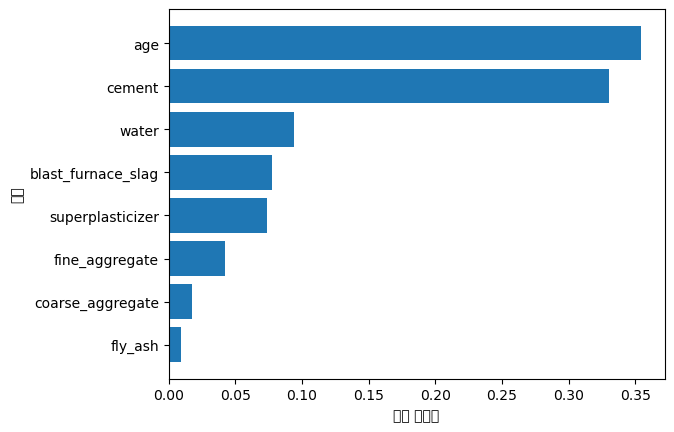

In [ ]:
df_importance.sort_values("importance",ascending=True, inplace= True)
coordinates= range(len(df_importance))
plt.barh(y= coordinates, width= df_importance["importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")
plt.show()